In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [23]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv", "Malfunction_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.359751,0.001825,0.000454,0.010020,0.011058,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
1,0.437500,0.086186,0.000216,0.010020,0.810513,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
2,0.500000,0.023501,0.000233,0.010020,0.062487,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
3,0.421875,0.007019,0.000236,0.010191,0.041340,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
4,0.359375,0.066017,0.000237,0.010041,0.205859,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
...,...,...,...,...,...,...,...,...,...,...
132646,0.500000,0.000000,0.000239,0.010094,0.010094,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132647,0.437500,0.046875,0.000235,0.010094,12.029791,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132648,0.484375,0.015625,0.000234,0.010092,0.039899,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132649,0.453125,0.000000,0.000232,0.010092,0.010092,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [24]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X_train_original = df.copy()

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,-0.121991,-0.313869,13.275199,0.004625,-0.033193,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
1,0.500000,0.585981,-1.626866,0.004628,0.881146,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
2,1.000000,-0.082654,-0.552239,0.004628,0.025627,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
3,0.375000,-0.258460,-0.388060,0.141613,0.001441,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
4,-0.125000,0.370846,-0.298507,0.021159,0.189602,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
...,...,...,...,...,...,...,...,...,...,...
132646,1.000000,-0.333333,-0.179104,0.064085,-0.034295,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132647,0.500000,0.166667,-0.447761,0.063895,13.712661,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132648,0.875000,-0.166667,-0.492537,0.062369,-0.000207,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132649,0.625000,-0.333333,-0.626866,0.062369,-0.034297,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [26]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [27]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		11157		4817
Attack		11157		4817


In [28]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [31]:
X_train_original.drop(columns=["type", "dataset", "name", "class", "Label"], inplace=True, errors="ignore")
X_train_original = X_train_original.loc[X_train.index]

Deep Neural Network

In [35]:
import keras
from keras import layers
# from tensorflow import keras
# from keras import layers

dnn = keras.models.Sequential(
    [
        keras.Input(shape=(len(X_train.columns),), name="input"),
        layers.Dense(23, activation='relu', name="layer_1"),
        layers.Dense(13, activation='relu', name="layer_2"),
        layers.Dense(7, activation='relu', name="layer_3"),
        layers.Dense(1, activation='sigmoid', name="output")
    ]
)



dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)

val_percent = int(len(y_train) * 0.1)
X_val = X_train.sample(val_percent, random_state=0) # X_train[-val_percent:]
y_val = y_train.loc[X_val.index] # y_train[-val_percent:]
X_train = X_train.loc[~X_train.index.isin(X_val)] # X_train[:-val_percent]
X_train_original = X_train_original.loc[~X_train.index.isin(X_val)]
y_train = y_train.loc[~y_train.index.isin(X_val)] # y_train[:-val_percent]

dnn.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/10
224/224 [==============================] - 1s 2ms/step - loss: 0.3661 - binary_accuracy: 0.8923 - recall_1: 0.9741 - false_negatives_1: 289.0000 - val_loss: 0.1195 - val_binary_accuracy: 0.9839 - val_recall_1: 0.9956 - val_false_negatives_1: 5.0000
Epoch 2/10
224/224 [==============================] - 0s 2ms/step - loss: 0.0759 - binary_accuracy: 0.9845 - recall_1: 0.9955 - false_negatives_1: 50.0000 - val_loss: 0.0503 - val_binary_accuracy: 0.9852 - val_recall_1: 0.9947 - val_false_negatives_1: 6.0000
Epoch 3/10
224/224 [==============================] - 0s 1ms/step - loss: 0.0483 - binary_accuracy: 0.9854 - recall_1: 0.9933 - false_negatives_1: 75.0000 - val_loss: 0.0375 - val_binary_accuracy: 0.9861 - val_recall_1: 0.9956 - val_false_negatives_1: 5.0000
Epoch 4/10
224/224 [==============================] - 0s 1ms/step - loss: 0.0428 - binary_accuracy: 0.9853 - recall_1: 0.9925 - false_negatives_1: 84.0000 - val_loss: 0.0586 - val_binary_accuracy: 0.9870 - val_recall_1: 0.

In [36]:
pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

pred_test = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.9910(+/- 0.0000)
Testing F1:  0.9889(+/- 0.0000)
Kappa score:  0.9778(+/- 0.0000)


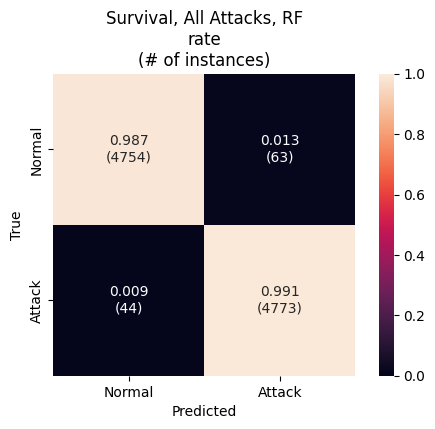

In [37]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [38]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train.sample(100, random_state=1))
print(exp.expected_value)

[0.42974946]


In [39]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_train) - dnn.predict_proba(X_train)).max() < 1e-4

X_train_exp = X_train.sample(min(len(X_train), 600), random_state=0)
X_train_exp_original = X_train_original.loc[X_train_exp.index]
y_train_exp = y_train[X_train_exp.index]

shap_all = get_explanation(exp, X_train_exp)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

100%|██████████| 600/600 [00:16<00:00, 35.36it/s]


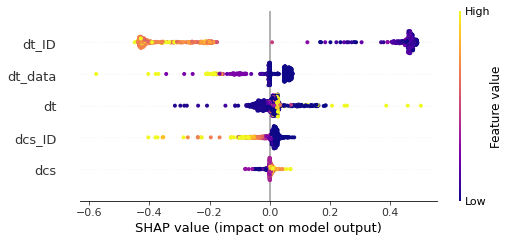

In [43]:
plot_beeswarm(shap_all)

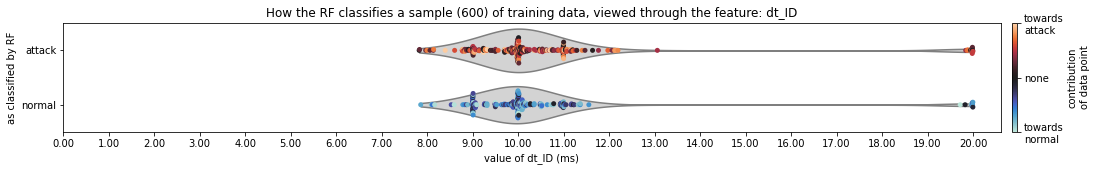

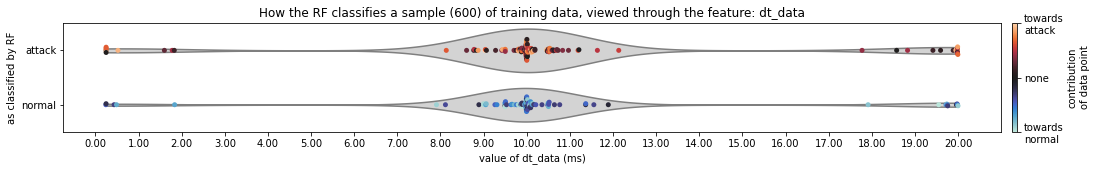

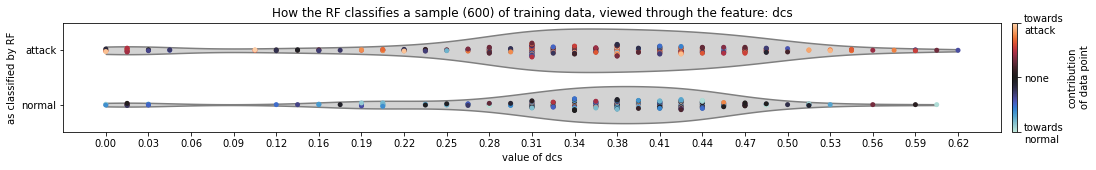

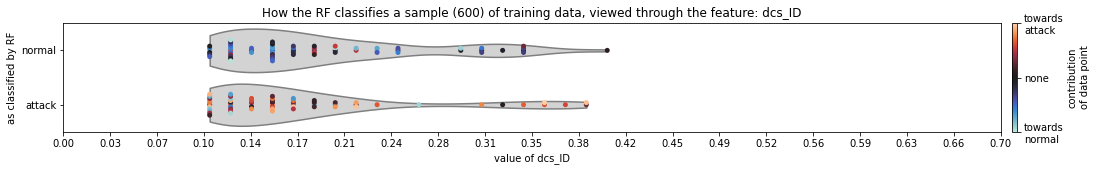

In [44]:
plot_exp(pd.concat([X_train_exp_original, y_train_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=True)
plot_exp(pd.concat([X_train_exp_original, y_train_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=True)
# plot_exp(pd.concat([X_train_exp, y_train_exp], axis=1), shap_all, "dt_d3", trim=(0, 0.02), scale=True, y_squish=15)
plot_exp(pd.concat([X_train_exp_original, y_train_exp], axis=1), shap_all, "dcs", trim=None, y_squish=25)
plot_exp(pd.concat([X_train_exp_original, y_train_exp], axis=1), shap_all, "dcs_ID", trim=(0.1, 0.7), y_squish=5)

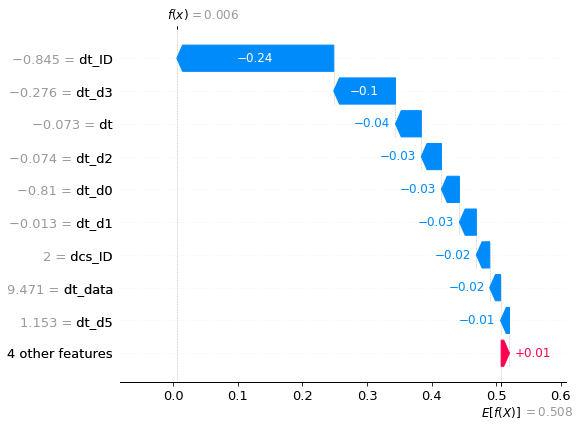

In [ ]:
plot_waterfall(shap_all, 0)

In [ ]:
plot_force(shap_all[0])

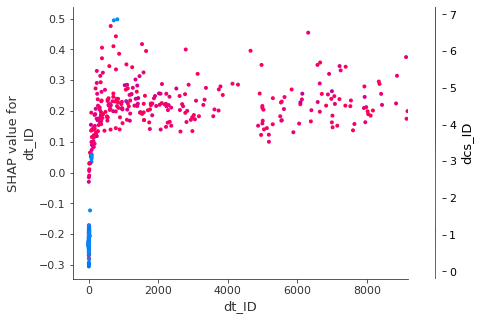

In [ ]:
plot_dependence(shap_all, "dt_ID", "dcs_ID", xmax="percentile(99)")

In [ ]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

array([[  2.8035035,   0.       ,   0.       ,   3.9883833,   0.       ],
       [  0.       ,   0.       ,   0.       ,  10.096009 ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   3.4852576,   0.       ],
       ...,
       [  0.       ,  22.874123 ,   0.       ,   0.       ,  22.220098 ],
       [  0.       , 338.0699   ,   0.       ,   0.       ,  29.941309 ],
       [  0.       ,  28.184793 ,   0.       ,   0.       ,   6.2021675]],
      dtype=float32)

In [ ]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [ ]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


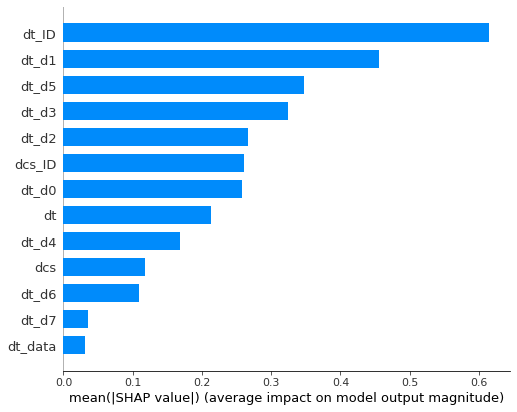

In [ ]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")